In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
path = os.path.abspath('/content/gdrive/Shared drives/2040_project/LSY ARCHIVE/models')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Introduction

In studies of image recognition, many of them have gray-scale pictures like chest radiographs. Currently, the idea of training those images is to apply models that are essentially designed for training colour pictures, such as DenseNet. This can cause many redundant parameters during the process. Therefore, this project aimed to discover a methodology to modify the models trained on colored images and to apply them to gray-scale images.


In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [3]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation, SpatialDropout2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from keras.layers import Concatenate
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import MinMaxScaler
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans
from sklearn.metrics import mean_squared_error
from scipy import spatial
import re
import math
mmscaler = MinMaxScaler()

Using TensorFlow backend.


In order to change the architecture of the DenseNet model to fit gray-scale images, this project planned to visualize the filters in each conv layer. Therefore, the original model and dataset were loaded here at the beginning.  


# 1.Load Original DenseNet Model

In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 100
l = 12
num_filter = 36 #added 24 more filters
compression = 0.5 
dropout_rate = 0.2
img_height, img_width, channel = 32, 32, 3

In [0]:
# Dense Block
# removed the dropout
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        #if dropout_rate>0:
         # Conv2D_3_3 = Dropout2D(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False, kernel_regularizer = regularizers.l1() ,padding='same')(relu)
    #if dropout_rate>0:
      #Conv2D_BottleNeck = Dropout2D(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
# converted the last Dense Layer to a Fully Convolution N/w as use of Dense Layer was prohibited
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    temp = Conv2D(num_classes, kernel_size = (2,2))(AvgPooling)
    output = Activation('softmax')(temp)
    flat = Flatten()(output)
    
    return flat

In [0]:
num_filter = 36
dropout_rate = 0.2
l= 12
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


In [9]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 36)   972         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 36)   144         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 36)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
model.load_weights(path + '/190epochs.h5')

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(0.01, momentum = 0.7),
              metrics=['accuracy'])

# 2.Load Image

In [0]:
# Load CIFAR10 Data
import numpy as np
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = tf.image.rgb_to_grayscale(x_train, name=None)
x_train = tf.broadcast_to(x_train, [50000, 32, 32, 3])
x_test = tf.image.rgb_to_grayscale(x_test, name=None)
x_test = tf.broadcast_to(x_test, [10000, 32, 32, 3])
x_train = x_train.numpy()
x_test = x_test.numpy()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 11s 0us/step


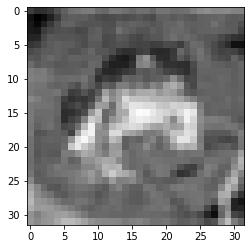

In [0]:
img_tensor = x_train[0]
img_tensor = np.expand_dims(img_tensor, axis=0)
plt.imshow(img_tensor[0])

# 3.Reduce Number of Filters

This section shows the method of reducing the number of filters in the conv layer of DenseNet model.

## 3.1 Visualize filters

The first step is to visualize the filters in each conv layer. The filters were represented by their visualization using gradient ascent in input space. Such visualization shows the image that can light up each filter the most.

This notebook only shows an example of the process in the first conv layer of the model. In the actual project, the team reduced the filters in the first two conv layers, because many of their filters show similarity in grayscale. The deeper the model is, the fewer the filters look similar. 

The first conv layer was modified to only take a single gray-scale channel as input. 

In [0]:
def deprocess_image_grayscale_for_plot(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')

    # convert to grayscale by averaging across 3 channels
    # x = np.mean(x, axis=2)
    x = np.dot(x[...,:3], [0.2989, 0.5870, 0.1140])

    return x

def deprocess_image_grayscale(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to grayscale by averaging across 3 channels
    # x = np.mean(x, axis=2)
    x = np.dot(x[...,:3], [0.2989, 0.5870, 0.1140])

    return x

def deprocess_image_color(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
def generate_pattern(model, layer_name, filter_index, size=32, grayscale=True, for_plot=False):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 0.5
    for i in range(100):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]

    if grayscale:
        if not for_plot:
            return deprocess_image_grayscale(img)
        else:
            return deprocess_image_grayscale_for_plot(img)

    if not grayscale:
        return deprocess_image_color(img)

In [0]:
def plot_filters(model_name, layer_list, img_size, mar, 
                 row = 3, col = 6, 
                 greyscale_flag = True, plot_flag = True, col_customized=None):
    """Plot all filters in a layer"""
    for layer_name in layer_list:
        size = img_size
        margin = mar
        for_trans = []
        if not greyscale_flag:
            results = np.zeros((row * size + 7 * margin, col * size + 7 * margin, 3))
        else:
            # This a empty (black) image where we will store our results.
            results = np.zeros((row * size + 7 * margin, col * size + 7 * margin))

        for i in range(row):  # iterate over the rows of our results grid
            for j in range(col):  # iterate over the columns of our results grid
                # Generate the pattern for filter `i + (j * 6)` in `layer_name`
                
                filter_img = generate_pattern(model_name, layer_name, j + (i * row), size=size, grayscale=greyscale_flag, for_plot=plot_flag)
                  
                # Put the result in the square `(i, j)` of the results grid
                horizontal_start = i * size + i * margin
                horizontal_end = horizontal_start + size
                vertical_start = j * size + j * margin
                vertical_end = vertical_start + size
                if not greyscale_flag:
                    results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img/255
                else:
                    results[horizontal_start: horizontal_end, vertical_start: vertical_end] = filter_img / 255
                #print(np.amin(filter_img[:]), np.amax(filter_img[:]))
            print('Finished filter no.', j + (i * row), "in", layer_name, end= '.  ')
        # Display the results grid
        print(layer_name)
        plt.figure(figsize=(15, 15))
        if col_customized:
            plt.imshow(results, cmap=col_customized)
        else:
            plt.imshow(results)
        plt.show()

### 3.1.1 All Filters in Color

The figure below shows the filters in the first conv layer. Each square represents a specific filter.


Finished filter no. 5 in conv2d_1.  Finished filter no. 11 in conv2d_1.  Finished filter no. 17 in conv2d_1.  Finished filter no. 23 in conv2d_1.  Finished filter no. 29 in conv2d_1.  Finished filter no. 35 in conv2d_1.  conv2d_1


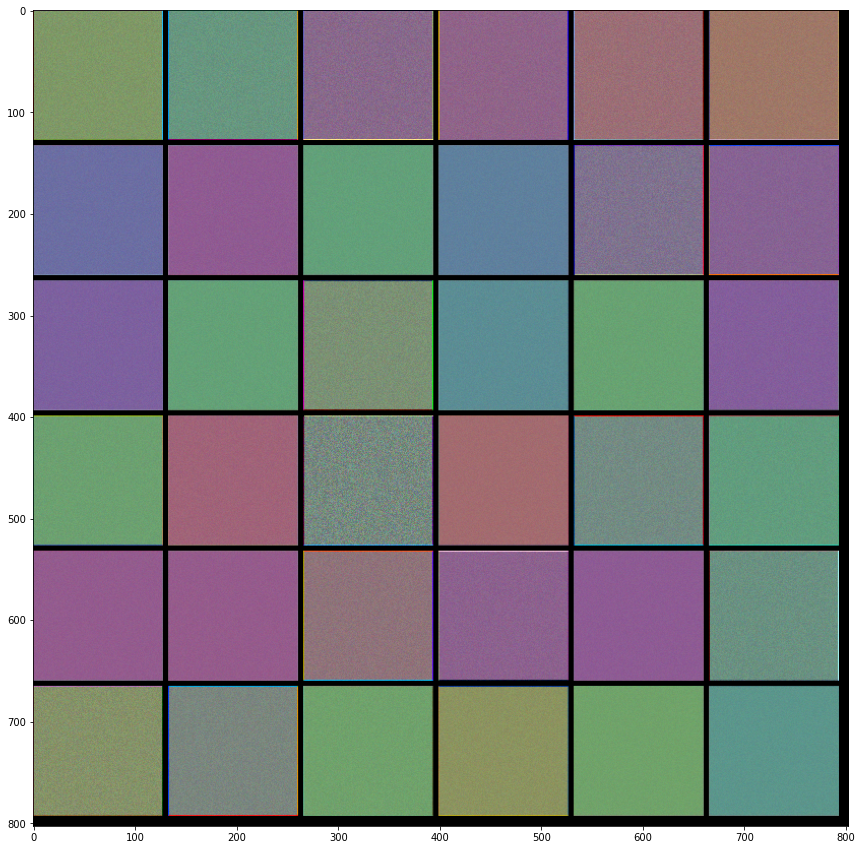

In [0]:
plot_filters(model, ["conv2d_1"], 128, 5, row = 6, col = 6, greyscale_flag = False, plot_flag = True)

### 3.1.2 All Filters in Grayscale

Since the input images are gray-scale images, these representations were converted to grayscale as well by adding linear weights to the RGB channel values. This is the same method as changing color images to gray-scale images used in image preprocessing. The processed images can then represent what each filter is looking for in a gray-scale feature space.  Figure below shows the gray-scale filters after the transformation of the figure above. Again, each square represents a specific filter. To increase the contrast for better visualization, the gray-scale filters were represented by blue and yellow.  


Finished filter no. 5 in conv2d_1.  Finished filter no. 11 in conv2d_1.  Finished filter no. 17 in conv2d_1.  Finished filter no. 23 in conv2d_1.  Finished filter no. 29 in conv2d_1.  Finished filter no. 35 in conv2d_1.  conv2d_1


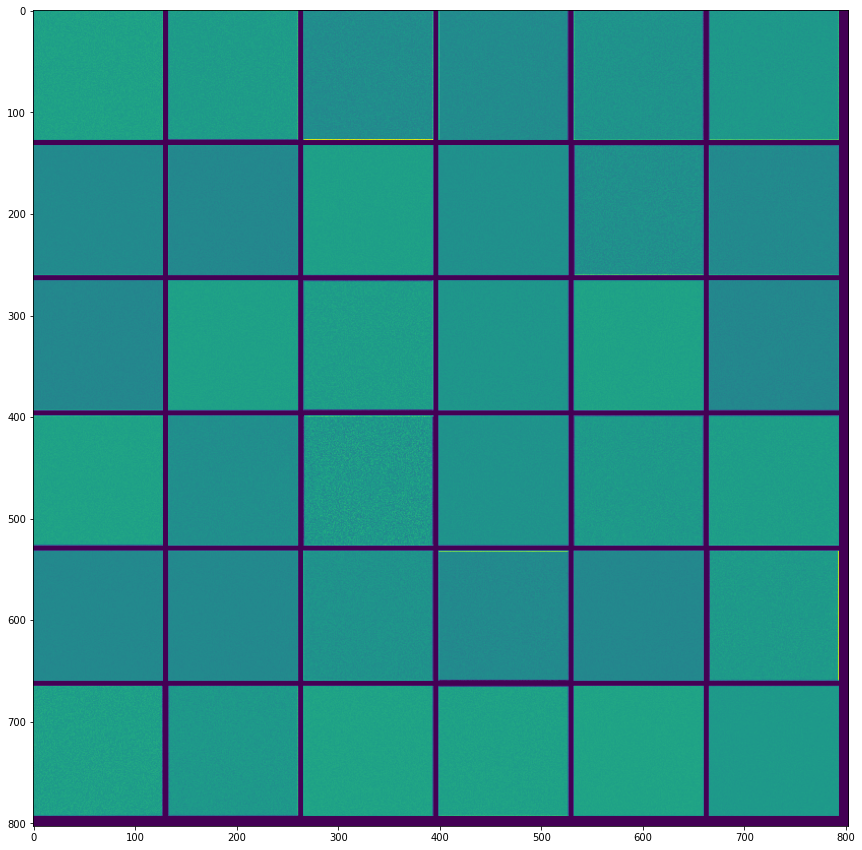

In [0]:
plot_filters(model, ["conv2d_1"], 128, 5, row = 6, col = 6, greyscale_flag = True, plot_flag = True)

## 3.2 Cluster Filters

After picking the layers, DBSCAN was used to cluster filters. Previous studies used k-means clustering to cluster the CNN kernels . The team found that k-means always results in evenly distributed kernels across different clusters, being not suitable for this case with only 18 filters for the convolutional layers. 

Two ways were applied to measure the distances between every two filters in matrix forms for clustering. MSE was applied in the first layer, and IMED was used in the second layer. A threshold was set to select filters that can be grouped together. A threshold was set to select filters that can be grouped together. 


In [0]:
# Get filter information to an array
def get_filter_array(model_name, layer_name, filter_num):
    filter_collection = []
    for i in range( filter_num):
        filter_img_temp = generate_pattern(model_name, layer_name, i, size=32, grayscale=True, for_plot=False)
        filter_collection.append(filter_img_temp)
    filter_collection = np.array(filter_collection)
    return filter_collection

In [0]:
def get_G(img_h, r):
    '''calculate Pixel Distance for IMED'''
    G_matrix = np.zeros((img_h**2, img_h**2))
    for i1 in range(img_h):
        for i2 in range(img_h):
            for j1 in range(img_h):
                for j2 in range(img_h):
                    pixel_dist = 1/(2*math.pi*(r**2)) * math.exp(-((i1-i2)**2 + (j1-j2)**2)/(2*r**2))
                    G_matrix[img_h*i1+j1, img_h*i2+j2] = pixel_dist
    return G_matrix
G = get_G(32, 1)

In [0]:
def get_imed(img1, img2):
    '''Calculate Image distance'''
    img1 = img1.flatten()
    img2 = img2.flatten()
    distance = math.sqrt(np.dot(np.dot(np.transpose(img1-img2), G), (img1-img2)))
    return distance

MSE, SSIM, cosine similarity, brightness and IMED are all methodologies to measure the distances between every two matrices. After trying them, the team found that MSE worked the best in the first conv layer which can be seen as a color palette. IMED gave the best result in the second layer which still contained most color information. 

In [0]:
def calculate_dist(filter_collection, method="mse"):
    filter_num = filter_collection.shape[0]
    print("Calculated Distance Matrix Using", method, "Method.")
    print("Filter number:", filter_num)
    if method == "ssim": # calculate distance matrix using ssim
        filter_distance_matrix_ssim = np.zeros((filter_num, filter_num))
        for i in range(filter_num):
            for j in range(filter_num):
                filter_distance_matrix_ssim[i, j] = ssim(filter_collection[i], filter_collection[j])
        filter_distance_matrix_ssim = 1 - filter_distance_matrix_ssim
        return filter_distance_matrix_ssim

    if method == "mse": # calculate distance matrix using mse
        filter_distance_matrix_mse = np.zeros((filter_num, filter_num))
        for i in range(filter_num):
            for j in range(filter_num):
                filter_distance_matrix_mse[i, j] = mean_squared_error(filter_collection[i].flatten(), filter_collection[j].flatten())
        return filter_distance_matrix_mse

    if method == "consine": # calculate distance matrix using cosine
        filter_distance_matrix_cosine = np.zeros((filter_num, filter_num))
        for i in range(filter_num):
            for j in range(filter_num):
                filter_distance_matrix_cosine[i, j] = \
                1 - spatial.distance.cosine(filter_collection[i].flatten(), filter_collection[j].flatten())
        filter_distance_matrix_cosine = 1 - filter_distance_matrix_cosine
        return filter_distance_matrix_cosine
    
    if method == "brightness": # calculate distance matrix using brightness
        filter_distance_matrix_brightness = np.zeros((filter_num, filter_num))
        for i in range(filter_num):
            for j in range(filter_num):
                filter_distance_matrix_brightness[i, j] = \
                np.sum(filter_collection[i]) - np.sum(filter_collection[j])
        filter_distance_matrix_brightness = mmscaler.fit_transform(filter_distance_matrix_brightness.flatten().reshape(-1, 1)).reshape((filter_num, filter_num))
        return filter_distance_matrix_brightness
    if method == "imed":
        filter_distance_matrix_imed = np.zeros((filter_num, filter_num))
        for i in range(filter_num):
            for j in range(filter_num):
                filter_distance_matrix_imed[i, j] = get_imed(filter_collection[i].flatten(), filter_collection[j].flatten())
        return filter_distance_matrix_imed

In [0]:
def get_cluster_(distance_mat, weight, row, col, min_samp=1):
    h = len(distance_mat)
    distance_mat = mmscaler.fit_transform(distance_mat.flatten().reshape(-1,1)).reshape(h, h)
    std = np.std([distance_mat[i, j] for i in range(h) for j in range(h) if i != j])
    clustering = DBSCAN(eps=weight, 
                    min_samples=min_samp, metric='precomputed').fit(distance_mat)
    filter_clusters = clustering.labels_
    return filter_clusters

In [0]:
conv2d_1 = get_filter_array(model, 'conv2d_1', 36)
conv2d_1_mse = calculate_dist(conv2d_1, method="mse")

Calculated Distance Matrix Using mse Method.
Filter number: 36


In the first conv layer, there are 36 filters in total, and they were clustered into 20 groups. 

In [0]:
filter_clusters = get_cluster_(conv2d_1_mse, weight=0.027, row=6, col=6, min_samp=1)
print('Number of clusters:', max(filter_clusters) + 1)
filter_clusters.reshape(6, 6)

Number of clusters: 20


array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  6,  7,  6,  8,  6],
       [ 6,  7,  9, 10,  7,  6],
       [ 7,  6, 11,  6, 12, 13],
       [ 6,  6, 10, 14,  6, 15],
       [16, 17, 18, 19,  7, 13]])

## 3.3 Merge Filters

Every filter is a three-dimension tensor. As for the convolutional layers that need to be shrunk, the filters were simply averaged within each cluster. However, doing this also reduced the number of output channels and causes shape mismatch. Therefore, for the following convolutional layer, the weights in each filter were added across the third dimension according to how we clustered the previous layer. 

In [0]:
def merge_filters(original_weights, cluster_res, 
                  cluster_res_prev=np.array([0, 0, 0]), layer_type='conv'):
    """
    Merge original weights, 
    based on clustering results and number of in_channels
    """

    # clean clustering result for outliers, record them as a new cluster
    max_cluster = max(cluster_res)
    for i, cls in enumerate(cluster_res):
        if cls == -1:
            max_cluster += 1
            cluster_res[i] = max_cluster
        
    # clean prev clustering result for outliers, record them as a new cluster
    max_cluster_prev = max(cluster_res_prev)
    for i, cls in enumerate(cluster_res_prev):
        if cls == -1:
            max_cluster_prev += 1
            cluster_res_prev[i] = max_cluster_prev

    if layer_type == 'conv':
        # average over the 4th dimension
        # zero tensor to record weights
        clustered_weights = np.zeros(list(original_weights.shape[:3]) + [max_cluster + 1])

        # load new filters with averaged weights
        for filter_idx in range(max_cluster + 1):
            # get index for the filters belong to that cluster
            idx = tf.constant([i for i in range(len(cluster_res)) if cluster_res[i] == filter_idx])
            # reduce average over the filters
            clustered_filter = tf.reduce_mean(tf.gather(original_weights, idx, axis=3), axis=3)
            clustered_weights[:, :, :, filter_idx] = clustered_filter

        # sum over the 3rd dimension according to previous cluster results
        # zero tensor to record weights
        reduced_clustered_weights = np.zeros(list(original_weights.shape[:2]) + [max_cluster_prev + 1] + [max_cluster + 1])

        # load new filters with sumed weights
        for filter_idx in range(max_cluster_prev + 1):
            # get index for the filters belong to that cluster
            idx = tf.constant([i for i in range(len(cluster_res_prev)) if cluster_res_prev[i] == filter_idx])
            # reduce average over the filters
            sumed_filter = tf.reduce_sum(tf.gather(clustered_weights, idx, axis=2), axis=2)
            reduced_clustered_weights[:, :, filter_idx, :] = sumed_filter

        return reduced_clustered_weights

    if layer_type == 'bn':
        # average the weights across channels
        # list to record weights
        clustered_weights = [np.zeros([max_cluster + 1]), 
                             np.zeros([max_cluster + 1]), 
                             np.zeros([max_cluster + 1]), 
                             np.zeros([max_cluster + 1])]

        # load new filters with averaged weights
        for bn_idx, bn_weights in enumerate(clustered_weights):
            for filter_idx in range(max_cluster + 1):
                # get index for the filters belong to that cluster
                idx = tf.constant([i for i in range(len(cluster_res)) if cluster_res[i] == filter_idx])
                # reduce average over the filters
                clustered_filter = tf.reduce_mean(tf.gather(original_weights[bn_idx], idx, axis=0), axis=0)
                bn_weights[filter_idx] = clustered_filter
        return clustered_weights

In [0]:
test_conv_1 = merge_filters(model.get_layer('conv2d_1').weights[0], filter_clusters, np.array([0, 0, 0]), layer_type='conv')
print('Shape of clustered 1st conv layer:', test_conv_1.shape)

Shape of clustered 1st conv layer: (3, 3, 1, 20)


In [0]:
test_bn_1 = merge_filters(model.get_layer('batch_normalization_1').weights, filter_clusters, layer_type='bn')
print('Shape of clustered 1st bn layer:', test_bn_1[0].shape)

Shape of clustered 1st bn layer: (20,)


In [0]:
test_conv_2 = merge_filters(model.get_layer('conv2d_2').weights[0], np.arange(18), filter_clusters, layer_type='conv')
print('Shape of 2nd conv layer:', test_conv_2.shape)

Shape of 2nd conv layer: (3, 3, 20, 18)


## 3.4 Load Weights

This section loads the preseved weights from the original model and the adjusted weights from the clustering step. These weights are used together for building the new model and comparing results with the old model.

In [0]:
num_filter = 36
dropout_rate = 0.2
l= 12
input = Input(shape=(img_height, img_width, 1,))
First_Conv2D = Conv2D(test_conv_1.shape[-1], (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

model_clustered = Model(inputs=[input], outputs=[output])

In [0]:
model_clustered.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 32, 32, 20)   180         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 32, 32, 20)   80          conv2d_55[0][0]                  
__________________________________________________________________________________________________
activation_54 (Activation)      (None, 32, 32, 20)   0           batch_normalization_53[0][0]     
____________________________________________________________________________________________

In [0]:
# load previous weights
layer_weight_dic = {}
for layer_idx in range(len(model.layers)):
    layer_name_clustered = model_clustered.layers[layer_idx].name
    layer_weights_prev = model.layers[layer_idx].get_weights()
    layer_weight_dic[layer_name_clustered] = layer_weights_prev

In [0]:
# update to new weights
layer_weight_dic['conv2d_55'] = [test_conv_1]
layer_weight_dic['conv2d_56'] = [test_conv_2]
layer_weight_dic['batch_normalization_53'] = test_bn_1
bn_count = 54
conv_count = 57
num_clusters = max(filter_clusters) + 1

for i in range(12):
    # get new height for conv and bn
    ttl_dim = model_clustered.get_layer(f'conv2d_{conv_count}').weights[0].shape[2]

    # update conv dimension
    tmp_wt_conv = merge_filters(model.get_layer(f'conv2d_{conv_count - 54}').weights[0], 
                            np.arange(18),
                            np.concatenate((filter_clusters, np.arange(num_clusters, ttl_dim))), 
                            layer_type='conv')
    layer_weight_dic[f'conv2d_{conv_count}'] = [tmp_wt_conv]

    # update bn dimension
    tmp_wt_bn = merge_filters(model.get_layer(f'batch_normalization_{bn_count - 52}').weights, 
                          np.concatenate((filter_clusters, np.arange(num_clusters, ttl_dim))), 
                          layer_type='bn')
    layer_weight_dic[f'batch_normalization_{bn_count}'] = tmp_wt_bn

    bn_count += 1
    conv_count += 1

In [0]:
# load new weights to model
for layer in model_clustered.layers:
    layer.set_weights(layer_weight_dic[layer.name])

In [0]:
# determine Loss function and Optimizer for the new model
model_clustered.compile(loss='categorical_crossentropy',
              optimizer=SGD(0.01, momentum = 0.7),
              metrics=['accuracy'])

# 4.Testing

## 4.1 Raw Results

The original DenseNet model gives an accuracy of 0.83, and the initial testing result is 0.73. This shows a significant loss of information during the process. The pipeline above preserved most of the image pattern information, but there is another important layer in DenseNet - batch normalization. These layers can be viewed as brightness and contrast adjustment. However, these features are not represented in the gradient ascend results, and they are hard to cluster. Therefore, these parameters were re-estimated by only training the batch normalization layer for one epoch, just to let it know the proper brightness after clustering. 

### 4.1.1 Original Model

In [0]:
_, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
test_accuracy
print('Original acc:', test_accuracy)

Original acc: 0.8320000171661377


### 4.1.2 Clustered Model

In [0]:
_, test_accuracy_clustered = model_clustered.evaluate(np.expand_dims(x_test[:, :, :, 0], axis=3), y_test, verbose=0)
print('Clustered acc:', test_accuracy_clustered)

Clustered acc: 0.7335000038146973


In [0]:
# Save model
model_name = 'densenet_clustered_1st_layer.h5'
model_clustered.save(model_name)

## 4.2 Only Train BN Layers

In [0]:
for layer in model_clustered.layers:
    if 'batch_normalization' not in layer.name:
        layer.trainable = False

# determine Loss function and Optimizer for the new model
model_clustered.compile(loss='categorical_crossentropy',
              optimizer=SGD(0.01, momentum = 0.7),
              metrics=['accuracy'])

In [0]:
model_clustered.fit(np.expand_dims(x_train[:, :, :, 0], axis=3), y_train, epochs = 1, verbose=0, 
                    validation_data = (np.expand_dims(x_test[:, :, :, 0], axis=3), y_test))

In [0]:
_, test_accuracy_clustered = model_clustered.evaluate(np.expand_dims(x_test[:, :, :, 0], axis=3), y_test, verbose=0)
print('Clustered acc after bn adjustment:', test_accuracy_clustered)

Clustered acc after bn adjustment: 0.8543000221252441


0.85 is the final accuracy of the new gray-scale model, which is slightly higher than the result given by baseline model. 

In [0]:
# Save model
model_name = 'densenet_clustered_1st_layer_bn_trained.h5'
model_clustered.save(model_name)

# Shortcomings

1. Depending on the method to merge filters, the information loss during the process can be significant. 
2. Gradient ascent gives slightly different results every time, so uncertainty exists in the process. 



# Potential Improvements

1. In order to reduce information loss, the method can be improved in terms of tuning the threshold value and changing the way of distance measurement and filter clustering.
2. In order to minimize uncertainty due to gradient ascent, average output can be taken over multiple ascent results.
